In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange
from flygym import Simulation, Camera
from flygym.arena import FlatTerrain



In this example, we will simulate a fly chasing another fly based on vision. This is similar to the [visual taxis task in week 4](https://github.com/NeLy-EPFL/cobar-exercises/blob/main/week4/1_vision.ipynb), but the ball will be replaced by a walking fly.

For multi-fly simulation, we might want to control the flies differently and have different observation/action spaces for different flies. Therefore, we will inherit from `Fly` and implement different logic in the `pre_step` method. 

In [2]:
from hybrid_turning_fly import HybridTurningFly
from movodor_arena import MovOdorArena
from odor_turning_fly import OdorTaxisFly
from female_decision_hybri_turn_fly import FemaleDecisionHybriTurnFly


In [3]:
# random state seed for reproducibility
seed = 1

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[0, 0, 0],[10, 0, 0]], dtype=np.float32)

# Peak intensities: array of shape (num_odor_sources, odor_dimensions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_odor_intensity = np.array([[1, 0],[1, 0]])

# odor threshold for male to stop, values found empirically
odor_threshold = 0.137
if peak_odor_intensity[0][0] == 0:
    odor_threshold = 0.057

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
marker_colors = [[255, 127, 14], [31, 119, 180]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimensions = len(peak_odor_intensity[0])

# Gains for the two odors (negative = attractive, positive = aversive)
odor_gains = np.array([-100, 100])

In [4]:
timestep = 1e-4
decision_interval = 0.05
run_time = 6

fly0 = OdorTaxisFly(  # This is the "chasing" fly (aka male fly)
    name="male",
    odor_threshold = odor_threshold, # Threshold found empiricly
    odor_dimensions=odor_dimensions,
    odor_gains=odor_gains,
    timestep=timestep,
    enable_adhesion=True,
    enable_olfaction=True,
    spawn_pos=(0, 0, 0),
)


fly1 = FemaleDecisionHybriTurnFly(  # This is the "chased" fly (aka female fly)
    name="female",
    timestep=timestep,
    enable_adhesion=True,
    enable_olfaction=True,
    spawn_pos=(10, 0, 0),
    odor_threshold = [0.119, 0.03] # Threshold found empiricly
)


arena = MovOdorArena(
    size=(300, 300),
    friction=(1, 0.005, 0.0001),
    num_sensors=4,
    move_speed=0,
    move_direction="right",
    odor_source=odor_source,
    peak_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,
    marker_colors=marker_colors,
    marker_size=0.3,
    no_odor_marker=False,
)

# THIS IS THE CAMERA THAT WILL BE USED FOR FOLLOWING THE CENTER OF MASS OF THE FLY
mov_birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="mov_birdeye_cam",
    mode="fixed",
    pos=(15, 0, 40), # (15, 0, 40) the 40 is the camera height which is constant
    euler=(0, 0, 0),
    fovy=45,
)
#-------------------------------------------------------------------------------

cam = Camera(
    fly=fly1,
    camera_id="birdeye_cam", # This is not used as argument
    play_speed=0.5,
    window_size=(800, 608),
)

cam_male = Camera(
    fly=fly0,
    camera_id="Animat/camera_left",
    window_size=(800, 608),
    play_speed=0.5,
)

cam_female = Camera(
    fly=fly1,
    camera_id="Animat/camera_right",
    window_size=(800, 608),
    play_speed=0.5,
)


sim = Simulation(
    flies=[fly0, fly1],
    cameras=[cam, cam_male, cam_female],
    arena=arena,
    timestep=timestep,
)

fly_names = [fly.name for fly in sim.flies]

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


[[0.11855754 0.11855995]
 [0.         0.        ]]


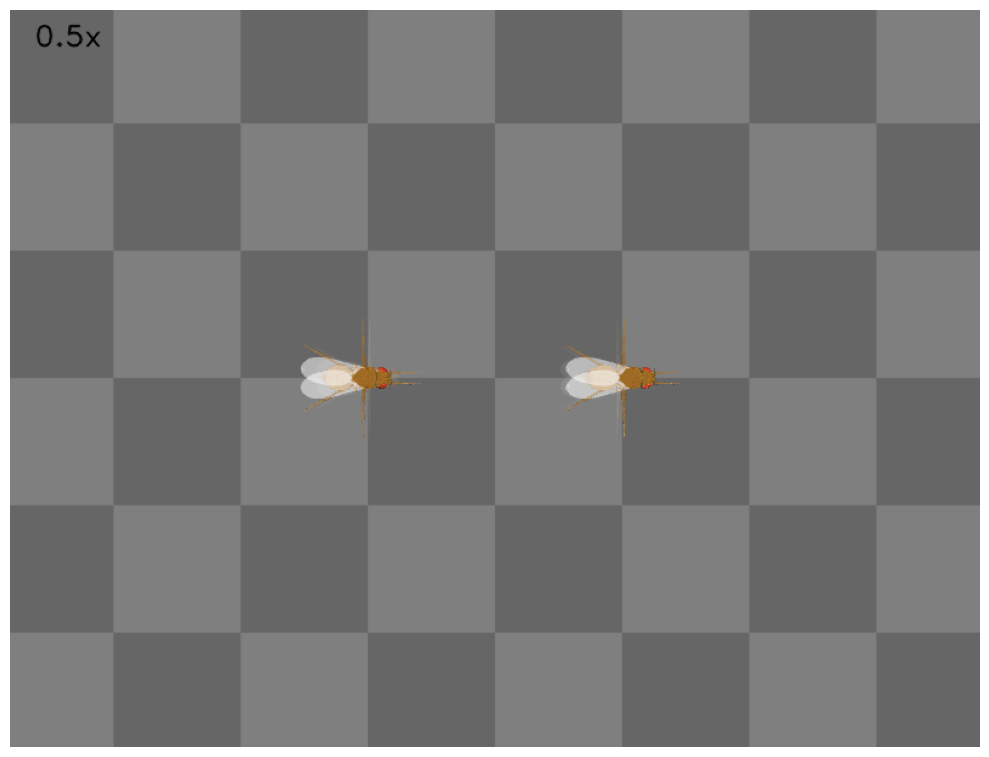

In [5]:
fly1.hybrid_turning = True
for i in trange(10):
    obs, _, _, _, info = sim.step({
                                "male": np.zeros(2),
                                "female": np.zeros(2)
                                })
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
ax.imshow(cam._frames[-1])
ax.axis("off")

odor = obs["male"]["odor_intensity"].reshape((odor_dimensions, 2, 2))
I = np.average(odor, axis=1, weights=[120, 1200])
# Calculate the left-right asymmetry in the odor intensities
I_l, I_r = I[:, 0], I[:, 1]
print(I)

threshold_male_attractive = 0.137  # threshold for the male to stop

threshold_male_aversive = 0.057  # threshold for the male to stop


acceptance_threshold_male_attractive = 0.135 # threshold for the female to accept male (this is the attractive threshold)

acceptance_threshold_male_aversive = 0.038  # threshold for the female to reject male (this is the aversive threshold)

### Construction of controlling signals and P1

In [6]:
def p1_control_signal(run_time: float, time_step: float) -> np.ndarray:
    """Returns a P1 signal [0,1].
    The control signal is a 2D array of shape (num_time_steps, 2)"""
    
    # P1 signal is a 2D array of shape (num_time_steps, 1)
    p1_signal = np.ones((int(run_time / time_step), 1))
    
    T_high = 1.5  # seconds
    T_low = 0.5  # seconds
    
    # Create a square wave signal with T_high and T_low= T_high/T_ratio
    signal_low = np.zeros(int(T_low / time_step))
    signal_high = np.ones(int(T_high / time_step))
    signal = np.concatenate([signal_high, signal_low])
    num_repeats = int(run_time / time_step / len(signal))
    p1_signal = np.tile(signal, num_repeats)
    # fille up the rest of the signal with ones (resting state)
    p1_signal = np.concatenate([p1_signal, np.ones(int(run_time / time_step) - len(p1_signal))])
    
    # Create a sine wave signal 
    #p1_signal[:, 0] = 0.5*(np.cos(0.5 * np.pi * np.linspace(0, run_time, int(run_time / time_step)))+1) 
    
    
    return p1_signal

def plot_signal(p1_signal, name: str):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
    ax.plot(np.linspace(0, run_time, int(run_time / decision_interval)), p1_signal)
    ax.set_xlabel("Time[s]")
    ax.set_ylabel(name)
    ax.set_title(name)
    plt.grid()

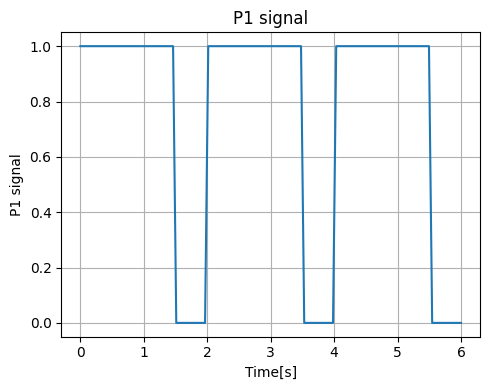

In [7]:
p1_signal = p1_control_signal(run_time, decision_interval)
plot_signal(p1_signal, "P1 signal")

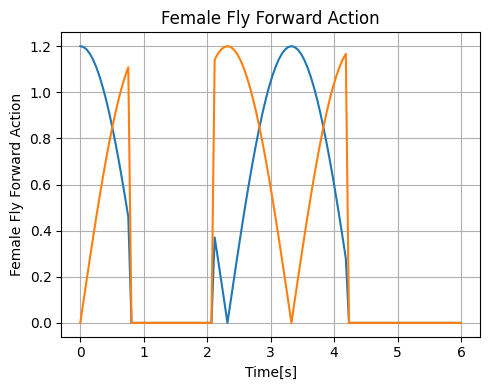

In [8]:
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / timestep)

t_stop_middle = 1.3
t_stop_end = 1.8
total_stop_time = t_stop_middle + t_stop_end # 1s stop at beginning, 2s stop at the end

t = np.arange(0, run_time-total_stop_time, decision_interval)

fly1_actions = (
    np.column_stack(
        [
            np.abs(np.cos(t * np.pi / 2)),
            np.abs(np.sin(t * np.pi / 2)),
        ]
    )
    * 1.2
)

stop1 = np.zeros((int(t_stop_middle / decision_interval), 2))
stop2 = np.zeros((int(t_stop_end / decision_interval), 2))

# insert stop 1 after 0.8 seconds
fly1_actions = np.vstack((fly1_actions[:int(0.8 / decision_interval)], stop1, fly1_actions[int(0.8 / decision_interval):]))

# insert stop 2 at the end
fly1_actions = np.vstack((fly1_actions, stop2))

assert len(fly1_actions) == num_decision_steps, f"Expected {num_decision_steps} decision steps, got {len(fly1_actions)}"

plot_signal(fly1_actions, "Female Fly Forward Action")

#### Run the simulation

In [9]:
from flygym.examples.common import PreprogrammedSteps

In [10]:
def lunging_behavior(
    target_num_steps: int
):
    """
    This function returns the preprogrammed steps for the lunging behavior.
    
    Args:
    - target_num_steps: int, number of steps to take
    
    Returns:
    - preprogrammed_steps: PreprogrammedSteps object
    - legs: list of strings, names of the legs
    - foreleg_ids: np.ndarray, ids of the forelegs
    - middle_stance_ids: np.ndarray, ids of the middle stance
    - hind_swing_ids: np.ndarray, ids of the hind swing
    - R_midleg_stretch: np.ndarray, joint angles for the right midleg
    - L_midleg_stretch: np.ndarray, joint angles for the left midleg
    - adhesion_action: np.ndarray, adhesion action
    """
    preprogrammed_steps=PreprogrammedSteps()
    swing_periods = preprogrammed_steps.swing_period
    legs = preprogrammed_steps.legs


    foreleg_ids = np.zeros(target_num_steps)
    middle_stance_ids = np.linspace(swing_periods["RM"][1], 2 * np.pi, target_num_steps)
    hind_swing_ids = np.linspace(0.0, swing_periods["RH"][1], target_num_steps)

    R_midleg_start = preprogrammed_steps.get_joint_angles("RM", swing_periods["RM"][1])
    R_midleg_stretch = np.linspace(
        np.zeros(len(R_midleg_start)), -R_midleg_start, target_num_steps
    )

    L_midleg_start = preprogrammed_steps.get_joint_angles("LM", swing_periods["LM"][1])
    L_midleg_stretch = np.linspace(
        np.zeros(len(L_midleg_start)), -L_midleg_start, target_num_steps
    )

    adhesion_action = np.array([0.0 if leg.endswith("F") else 1.0 for leg in legs])
    
    return preprogrammed_steps, legs, foreleg_ids, middle_stance_ids, hind_swing_ids, R_midleg_stretch, L_midleg_stretch, adhesion_action


In [11]:
def abdomen_bending_and_kicking_behavior(
    target_num_steps: int,
    timestep: float
) -> tuple:
    """
    This function returns the preprogrammed steps for abdomen bending and kicking behavior.
    
    Args:
    target_num_steps: int - The number of time steps for the simulation
    timestep: float - The time step for the simulation
    
    Returns:
    preprogrammed_steps: PreprogrammedSteps - The preprogrammed steps for the abdomen bending and kicking behavior
    legs: list - The list of legs
    swing_periods: dict - The swing periods for the legs
    data_block: np.ndarray - The data block for the abdomen bending and kicking behavior
    adhesion_action: np.ndarray - The adhesion action for the abdomen bending and kicking behavior
    """
    kick_action={}
    preprogrammed_steps = PreprogrammedSteps()
    legs = preprogrammed_steps.legs

    kick_action["joint_RHCoxa"]=np.concatenate([np.linspace(0,1, target_num_steps//2),np.linspace(1, 0, target_num_steps//2)]).tolist()

    kick_action["joint_RHCoxa_roll"]=np.linspace(0.7,0.7,target_num_steps).tolist()
    kick_action["joint_RHCoxa_yaw"]=np.linspace(0,0,target_num_steps).tolist()
    kick_action["joint_RHFemur"]=np.concatenate([np.linspace(2,2, target_num_steps//3),np.linspace(2,2.5, target_num_steps//3),np.linspace(2.5,1.7 , target_num_steps//3 +target_num_steps%3)]).tolist()
    kick_action["joint_RHFemur_roll"]=np.linspace(0,0, target_num_steps).tolist()
    kick_action["joint_RHTibia"]=np.concatenate([np.linspace(-1.0,-1.0, target_num_steps//3),np.linspace(-1.0,-2.0, target_num_steps//3),np.linspace(-2.0, 0, target_num_steps//3+target_num_steps%3)]).tolist()
    kick_action["joint_RHTarsus1"]=np.concatenate([np.linspace(0.3,0.3 ,target_num_steps//2),np.linspace(0.3,0 , target_num_steps//2)]).tolist()
    kick_action["joint_A1A2"]=np.linspace(0,0,target_num_steps).tolist()
    kick_action["joint_A3"]=np.linspace(0,0,target_num_steps).tolist()
    kick_action["joint_A4"]=np.linspace(0,-0.4,target_num_steps).tolist()
    kick_action["joint_A5"]=np.linspace(0,-0.6,target_num_steps).tolist()
    kick_action["joint_A6"]=np.linspace(0,0,target_num_steps).tolist()
    swing_periods = preprogrammed_steps.swing_period

    R_hindleg_start = preprogrammed_steps.get_joint_angles("RH", swing_periods["RH"][1])


    adhesion_action = np.array([0.0 if leg.endswith("RH") else 1.0 for leg in legs])

    actuated_joints=["joint_RHCoxa","joint_RHCoxa_roll","joint_RHCoxa_yaw","joint_RHFemur","joint_RHFemur_roll","joint_RHTibia","joint_RHTarsus1","joint_A1A2","joint_A3","joint_A4","joint_A5","joint_A6"]
    data_block = np.zeros((len(actuated_joints), target_num_steps))
    abdomen_joints=["joint_A1A2","joint_A3","joint_A4","joint_A5"]
    output_t=np.arange(target_num_steps)*timestep
    input_t = np.linspace(0, timestep * (target_num_steps - 1), num=target_num_steps)

    for i, joint in enumerate(actuated_joints):
        data_block[i,:] = np.interp(output_t, input_t, np.array(kick_action[joint]))
    
    return preprogrammed_steps, legs, swing_periods, data_block, adhesion_action  

In [12]:
# # Changes the color of the fly to black
# for i in fly1.model.find_all("geom"):
#     sim.physics.named.model.geom_rgba[f"female/{i.name}"] = (0, 0, 0, 1)

# For the camera following the fly
second_cam_frames = []
x = None
y = None
alpha = 1e-1
render = True
# Initialize the control signal
control_signal = np.zeros(odor_dimensions)
obs_history = []
odor_source_hist = []

fly1.hybrid_turning = True
female_state = "no_fly_nearby"

obs, _ = sim.reset(seed=seed)
print("Part 1: chasing")
for i in trange(num_decision_steps):

    #**********************************************************************************
    female_state = fly1.get_female_mating_decision(odor_intensities=obs["female"]["odor_intensity"], timestep=decision_interval, time_before_decision=2.0)
    if female_state == "reject" or female_state == "accept":
        print(f"female fly {female_state}ed the mating!")
        break


    #**********************************************************************************

    control_signal = fly0.process_odor_intensities(obs["male"]["odor_intensity"])
    control_signal *= p1_signal[i]
    
    for j in range(physics_steps_per_decision_step):
        #********************************************************************************************************************
        if female_state == "reject":
            break
        elif female_state == "accept":
            break
        elif female_state == "fly_nearby" or female_state == "no_fly_nearby":
            obs, _, _, _, info = sim.step(
            {
                "male": control_signal,
                "female": fly1_actions[i],
            }
            )
        #********************************************************************************************************************
            
        #To bind the odor source position to a fly position
        for j, name in enumerate(fly_names):
            arena.odor_source[j] = obs[name]["fly"][0]

        if render:
            #THIS PART IS TO MAKE THE SECOND CAMERA FOLLOW THE CENTER OF MASS OF THE FLY -----------
            render_res = sim.render()[0]

            if render_res is not None:
                second_cam = sim.physics.bind(mov_birdeye_cam)

                x_new = obs["male"]["fly"][0][0]
                y_new = obs["male"]["fly"][0][1]

                if x is None:
                    x = x_new
                
                if y is None:
                    y = y_new

                x = (1 - alpha) * x + alpha * x_new
                y = (1 - alpha) * y + alpha * y_new

                second_cam.pos[0] = x
                second_cam.pos[1] = y

                second_img = sim.physics.render(
                    width=700, height=560, camera_id="mov_birdeye_cam"
                )
                second_img = cv2.putText(
                    np.ascontiguousarray(second_img),
                    f"{sim.cameras[0].play_speed}x",
                    org=(20, 30),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX,
                    fontScale=0.8,
                    color=(0, 0, 0),
                    lineType=cv2.LINE_AA,
                    thickness=1,
                )
                second_cam_frames.append(second_img)
                #----------------------------------------------------------------------

        odor_source_hist.append(arena.odor_source.copy())
        obs_history.append(obs)

#**************************************************************************************
fly0.odor_turning = False
fly1.hybrid_turning = False

run_time = 0.5
target_num_steps = int(run_time / sim.timestep)


all_joint_angles = []
print(female_state)
if female_state == "no_fly_nearby" or female_state == "fly_nearby":
    female_state = fly1.get_female_mating_decision(obs["female"]["odor_intensity"], timestep=1, time_before_decision=0)
print(female_state)

preprogrammed_steps_male, legs_m, foreleg_ids, middle_stance_ids, hind_swing_ids, R_midleg_stretch, L_midleg_stretch, adhesion_action_male = lunging_behavior(target_num_steps)

preprogrammed_steps_female, legs_f, swing_periods, kick_action, adhesion_action_female = abdomen_bending_and_kicking_behavior(target_num_steps, sim.timestep)

print("Part 2: preprogrammed steps, female reaction")
for i in trange(target_num_steps):

    # For the male fly's action
    joint_angles = []
    for leg in legs_m:
        if leg.endswith("F"):
            joint_angles.extend(
                preprogrammed_steps_male.get_joint_angles(leg, foreleg_ids[i])
            )
        elif leg.endswith("M"):
            midleg_joint_angles = preprogrammed_steps_male.get_joint_angles(
                leg, middle_stance_ids[i]
            )
            if leg.startswith("R"):
                midleg_joint_angles += R_midleg_stretch[i]
            elif leg.startswith("L"):
                midleg_joint_angles += L_midleg_stretch[i]

            joint_angles.extend(midleg_joint_angles)
        else:
            joint_angles.extend(
                preprogrammed_steps_male.get_joint_angles(leg, hind_swing_ids[i])
            )

    all_joint_angles.append(joint_angles.copy())

    male_action = {"joints": np.array(joint_angles), "adhesion": adhesion_action_male}

    # For the female fly's action
    female_action = 0
    if female_state == "reject":
        fly1.hybrid_turning = False
        joint_angles = []
        for leg in legs_f:
            if leg.endswith("H"):
                if leg.startswith("R"):
                    joint_angles.extend(kick_action[:,i])
                elif leg.startswith("L"):
                    joint_angles.extend(preprogrammed_steps_female.get_joint_angles(
                    leg,swing_periods[leg][1]            ))
            
            elif leg.endswith("F"):
                joint_angles.extend(preprogrammed_steps_female.get_joint_angles(leg, swing_periods[leg][1]))
            else:
                joint_angles.extend(preprogrammed_steps_female.get_joint_angles(
                    leg,swing_periods[leg][1]            ))
        female_action = {"joints": np.array(joint_angles), "adhesion": adhesion_action_male}

    else:
        fly1.hybrid_turning = True
        female_action = np.zeros(2)

    
    obs, _, _, _, info = sim.step(
    {
        "male": male_action,
        "female": female_action,
    }
    )
    
    if render:
        #THIS PART IS TO MAKE THE SECOND CAMERA FOLLOW THE CENTER OF MASS OF THE FLY ------------------------------------------------
        render_res = sim.render()[0]

        if render_res is not None:
            second_cam = sim.physics.bind(mov_birdeye_cam)

            x_new = obs["male"]["fly"][0][0]
            y_new = obs["male"]["fly"][0][1]

            if x is None:
                x = x_new
            
            if y is None:
                y = y_new

            x = (1 - alpha) * x + alpha * x_new
            y = (1 - alpha) * y + alpha * y_new

            second_cam.pos[0] = x
            second_cam.pos[1] = y

            second_img = sim.physics.render(
                width=700, height=560, camera_id="mov_birdeye_cam"
            )
            second_img = cv2.putText(
                np.ascontiguousarray(second_img),
                f"{sim.cameras[0].play_speed}x",
                org=(20, 30),
                fontFace=cv2.FONT_HERSHEY_DUPLEX,
                fontScale=0.8,
                color=(0, 0, 0),
                lineType=cv2.LINE_AA,
                thickness=1,
            )
            second_cam_frames.append(second_img)
            #------------------------------------------------------------------------------------------------

    odor_source_hist.append(arena.odor_source.copy())
    obs_history.append(obs)



Part 1: chasing


 22%|██▏       | 26/120 [11:16<41:03, 26.21s/it]

Fly is close to the odor source, stopping the fly


 40%|████      | 48/120 [21:02<32:41, 27.24s/it]

Fly is close to the odor source, stopping the fly


 44%|████▍     | 53/120 [23:14<29:36, 26.51s/it]

Fly is close to the odor source, stopping the fly


 92%|█████████▎| 111/120 [49:05<04:06, 27.41s/it]

Fly is close to the odor source, stopping the fly


100%|██████████| 120/120 [53:14<00:00, 26.62s/it]


fly_nearby
accept
Part 2: preprogrammed steps, female reaction


100%|██████████| 5000/5000 [04:30<00:00, 18.50it/s]


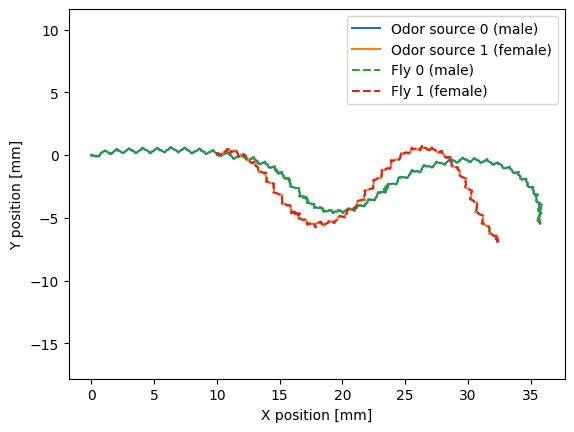

In [15]:
# plot the odor source trajectory vs fly trajectory
import matplotlib.pyplot as plt
fly_pos_hist_1 = np.array([obs["female"]["fly"][0, :2] for obs in obs_history])
fly_pos_hist_0 = np.array([obs["male"]["fly"][0, :2] for obs in obs_history])
odor_source_hist = np.array(odor_source_hist)
plt.plot(odor_source_hist[:,0,0], odor_source_hist[:,0,1], label="Odor source 0 (male)")
plt.plot(odor_source_hist[:,1,0], odor_source_hist[:,1,1], label="Odor source 1 (female)")
plt.plot(fly_pos_hist_0[:,0], fly_pos_hist_0[:,1], label="Fly 0 (male)", linestyle="--")
plt.plot(fly_pos_hist_1[:,0], fly_pos_hist_1[:,1], label="Fly 1 (female)", linestyle="--")
# set plot labels
plt.xlabel("X position [mm]")
plt.ylabel("Y position [mm]")
# fix size of the plot
plt.axis("equal")
plt.legend()
plt.show()

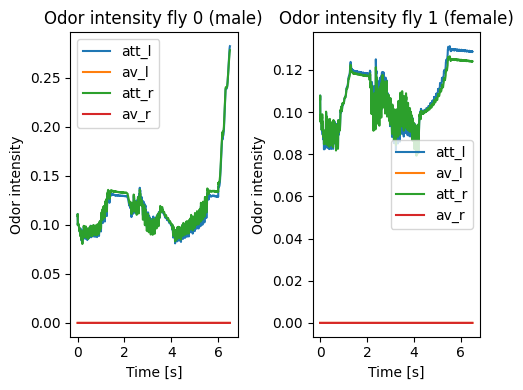

In [14]:
odor_history_fly0 = [np.average(obs_history[i]["male"]["odor_intensity"].reshape((odor_dimensions, 2, 2)), axis=1) for i in range(len(obs_history))]
odor_l_history = [odor_history_fly0[i][:, 0] for i in range(len(odor_history_fly0))]
odor_r_history = [odor_history_fly0[i][:, 1] for i in range(len(odor_history_fly0))]

odor_history_fly1 = [np.average(obs_history[i]["female"]["odor_intensity"].reshape((odor_dimensions, 2, 2)), axis=1) for i in range(len(obs_history))]
odor_l_history_fly1 = [odor_history_fly1[i][:, 0] for i in range(len(odor_history_fly1))]
odor_r_history_fly1 = [odor_history_fly1[i][:, 1] for i in range(len(odor_history_fly1))]

plot_odor_l = np.array(odor_l_history)
plot_odor_r = np.array(odor_r_history)
fig, ax = plt.subplots(1, 2, figsize=(5, 4), tight_layout=True)
time = np.linspace(0, (timestep*len(odor_history_fly0)), len(odor_history_fly0))
ax[0].title.set_text("Odor intensity fly 0 (male)")
ax[0].plot(time, plot_odor_l, label=["att_l", "av_l"])
ax[0].plot(time, plot_odor_r, label=["att_r", "av_r"])
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Odor intensity")
ax[0].legend()

plot_odor_l = np.array(odor_l_history_fly1)
plot_odor_r = np.array(odor_r_history_fly1)
ax[1].title.set_text("Odor intensity fly 1 (female)")
ax[1].plot(time, plot_odor_l, label=["att_l", "av_l"])
ax[1].plot(time, plot_odor_r, label=["att_r", "av_r"])
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Odor intensity")
ax[1].legend()

plt.show()

In [32]:
#birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames
cam.save_video("video_chasing/FINAL_birdeye.mp4")

In [33]:
from IPython.display import Video

Video("video_chasing/FINAL_birdeye.mp4", width=800, height=608)

In [34]:
cam_male.save_video("video_chasing/FINAL_sideview.mp4")

In [35]:
Video("video_chasing/FINAL_sideview.mp4", width=800, height=608)

In [36]:
cam_female.save_video("video_chasing/FINAL_sideview_female.mp4")

Video("video_chasing/FINAL_sideview_female.mp4", width=800, height=608)